#  Deep Learning Neural Network Model
### Multilayer Perceptron (MLP)

### Project Objective
The goal of this project is to demonstrate the application of machine learning techniques in cybersecurity by detecting fraudulent credit card transactions. The solution covers the **full pipeline**, from data preprocessing to model training, evaluation, generalizability testing, and deployment-ready model saving.

### Project Scope
- **Problem Identification**: Fraudulent transactions are costly and increasingly sophisticated. Early detection using ML reduces financial losses and operational burden.
- **Data Sources**:
  - **Primary dataset**: 2013 credit card transactions with labeled fraud cases.
  - **Secondary dataset**: 2023 dataset for generalizability testing to ensure robustness.
- **Models**:
  - **Deep Learning**: Multi-Layer Perceptron (MLP).
- **Evaluation Metrics**:
  - Precision, Recall, F1-score.
  - ROC-AUC, Confusion Matrix.
  - Threshold tuning to maintain desired precision (~0.80).

In [10]:
# ============================================
# Cell 1: Imports and environment setup
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix, auc
)
from imblearn.over_sampling import SMOTE
import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Environment ready. PyTorch device:", device)

Environment ready. PyTorch device: cpu


### Helper Plotting & Evaluation Functions

Following cell defines reusable functions that help visualize and evaluate model performance.  
These functions are called throughout the notebook to provide consistent, clear metrics and charts.

#### **Functions Included:**
- Generating a labeled confusion matrix using Seaborn.  
- Plotting the Receiver Operating Characteristic (ROC) curve.  
- Printing precision, recall, F1-score, and support using.

The tools implemented ensure that all models in this project are evaluated consistently.

In [11]:
# ============================================
# Cell 2: Helper plotting and metrics functions
# ============================================
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.4f}")
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

def classification_metrics(y_true, y_pred, y_scores=None):
    print(classification_report(y_true, y_pred, digits=4))
    if y_scores is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_scores))

### Kaggle Dataset
Downloading the primary dataset to be loaded into the model for training.

### [Dataset Link](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)


In [12]:
# ============================================
# Cell 3: Load dataset via KaggleHub
# ============================================
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded to:", path)

df = pd.read_csv(os.path.join(path, "creditcard.csv"))

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Dataset downloaded to: /kaggle/input/creditcardfraud


### Preprocessing for Deep Learning Model (MLP)

This cell prepares the credit card dataset for specifically training the **Multilayer Perceptron (MLP)** for fraud detection.

### **Steps**

1. **Log Transformation of Amount**
   - `Amount_log = np.log1p(df["Amount"])`  
   - Reduces skew in transaction amounts for better model performance.

2. **Drop Unnecessary Columns**
   - Removes Time, Amount, and Hour to focus on model-relevant features.

3. **Feature and Target Separation**
   - `X` contains all features except Class.
   - `y` contains the target labels (Class).

4. **Feature Scaling**
   - Uses StandardScaler to normalize features.
   - Saves the fitted scaler for consistent preprocessing during deployment.

5. **Train-Test Split**
   - Stratified split ensures class distribution is preserved.
   - Test size is 20% of the dataset.

6. **Handling Class Imbalance**
   - Applies **SMOTE** to oversample minority class in the training set.
   - Prevents the model from being biased toward majority class.

7. **Conversion to PyTorch Tensors**
   - Features and labels converted to torch.tensor for MLP training.

8. **DataLoader Preparation**
   - Creates `train_loader` and `val_loader` for batch-wise training and validation.
   - Batch size is 2048 for efficient GPU/CPU utilization.

The result is a scaled, oversampled, and batched datasets ready for MLP training. Training and test sample shapes are printed below for verification.


In [13]:
# ============================================
# Cell 4: Preprocessing
# ============================================
df["Amount_log"] = np.log1p(df["Amount"])
df_model = df.drop(["Time", "Amount", "Hour"], axis=1, errors="ignore")

X = df_model.drop("Class", axis=1)
y = df_model["Class"]

# Scale features and save scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "mlp_scaler_creditcard.joblib")
print("Scaler saved as mlp_scaler_creditcard.joblib")

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

# SMOTE oversampling
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_sm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sm.values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

print("Training samples:", X_train_tensor.shape, "Test samples:", X_test_tensor.shape)

Scaler saved as mlp_scaler_creditcard.joblib
Training samples: torch.Size([454902, 29]) Test samples: torch.Size([56962, 29])


### Deep Learning Model: Multilayer Perceptron (MLP)

The cell section implements the **deep learning model** for fraud detection, using a **neural network (MLP)**.

### **Rationale**
- Tabular data with numerical features can benefit from deep learning due to its ability to learn non-linear relationships between features.
- MLPs are capable of being able to capture complex interactions that may not be obvious in traditional tree-based models.
- While traditional ML (RandomForest and XGBoost) are robust for imbalanced tabular data, MLPs offer potential improvements in generalization and probability estimation.
- Considerations: Requires careful **feature scaling**, risk of overfitting, and situationally more training time compared to tree-based models.

### **Model Architecture**
- **Input Layer**: Size equals the number of features (`num_features`).
- **Hidden Layers**:
  1. 128 neurons + ReLU activation + Dropout(0.2)
  2. 64 neurons + ReLU activation + Dropout(0.2)
- **Output Layer**: 1 neuron with Sigmoid activation for binary classification (Fraud vs Legit).

### **Training Setup**
- **Loss Function**: Binary Cross-Entropy (`BCELoss`) – standard for binary classification.
- **Optimizer**: Adam with learning rate 0.001 – efficient for deep networks with adaptive updates.
- **Device**: Model is sent to the device (CPU/GPU) for optimized training.
- **Batching**: Data loaded using DataLoader for mini-batch training.

### **Notes**
- Dropout prevents overfitting by randomly disabling neurons during training.
- Fully-connected layers are well-suited for tabular numeric datasets.
- Scaling of features is critical for stable and effective training.
- This model provides a **deep learning complement** to traditional ML models, allowing comparison of performance across methodologies.


In [14]:
# ============================================
# Cell 5: Fully-Connected Neural Network (MLP)
# ============================================
class FraudMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

num_features = X_train_tensor.shape[1]
classifier = FraudMLP(num_features).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

### MLP Training: Overfitting Detection

The cell trains the previously defined **MLP model** and monitors potential overfitting.


### **Training Procedure**
- **Epochs**: 10 full passes over the training data.
- **Mini-Batch Training**: Uses DataLoader` with batches of size 2048.
- **Forward Pass**: Compute predictions for each batch.
- **Loss Calculation**: Binary Cross-Entropy (BCELoss) between predictions and true labels.
- **Backward Pass & Optimization**: Gradients computed via `loss.backward()`, weights updated using Adam optimizer.
- **Validation**: After each epoch, evaluate the model on the validation set to monitor generalization.

### **Overfitting Detection**
- **Train Loss vs Validation Loss**:
  - Train loss decreasing while validation loss plateaus or increases may indicate overfitting.
  - Plotting both losses helps identify if the model is learning meaningful patterns or memorizing the training data.

Monitoring validation loss ensures early detection of overfitting. The Dropout layers in the MLP also help reduce overfitting risk. Ultimately, this setup ensures the model is trained efficiently while providing metrics to assess its generalization capabilities.


Epoch 1/10, Train Loss: 0.1300, Val Loss: 0.0570
Epoch 2/10, Train Loss: 0.0327, Val Loss: 0.0471
Epoch 3/10, Train Loss: 0.0213, Val Loss: 0.0406
Epoch 4/10, Train Loss: 0.0154, Val Loss: 0.0378
Epoch 5/10, Train Loss: 0.0133, Val Loss: 0.0337
Epoch 6/10, Train Loss: 0.0112, Val Loss: 0.0325
Epoch 7/10, Train Loss: 0.0106, Val Loss: 0.0291
Epoch 8/10, Train Loss: 0.0090, Val Loss: 0.0284
Epoch 9/10, Train Loss: 0.0087, Val Loss: 0.0271
Epoch 10/10, Train Loss: 0.0075, Val Loss: 0.0285


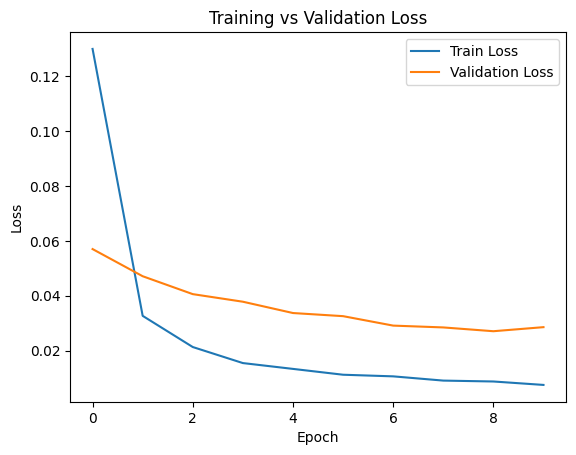

In [15]:
# ============================================
# Cell 6: Training (Overfitting detection)
# ============================================
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    classifier.train()
    epoch_train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = classifier(xb).squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Validation
    classifier.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = classifier(xb).squeeze()
            loss = criterion(pred, yb)
            epoch_val_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))
    val_losses.append(epoch_val_loss / len(val_loader))

    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_losses[-1]:.4f}, "
        f"Val Loss: {val_losses[-1]:.4f}"
    )

# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### MLP Evaluation and Threshold Selection

This cell evaluates the trained **MLP model** on the test set, selects an optimal classification threshold for high precision, and saves necessary artifacts for deployment.

### **Steps**

1. **Model Evaluation**
   - Sets the model to evaluation mode.
   - Compute predicted probabilities (`y_probs`) for the test set.

2. **Threshold Selection**
   - Desired precision is set to 0.80 to minimize false positives.
   - Use the **Precision-Recall curve** to find the threshold where precision meets or exceeds the target.
   - Ensures the model prioritizes business-relevant precision over recall.

3. **Prediction**
   - Convert probabilities to binary predictions using the selected threshold.
   - Evaluate using:
     - **Classification metrics**: precision, recall, F1-score
     - **Confusion matrix**: visualizes true vs predicted labels
     - **ROC curve**: visualizes tradeoff between TPR and FPR

4. **Persistence for Deployment**
   - Save the trained model
   - Save the feature scaler:
   - Save the selected optimal threshold
   - These components ensure consistent preprocessing and thresholding during real-time inference when deployed.

The result of this will be a fully evaluated MLP with business-prioritized threshold. Artifacts saved will be useful for the **real-time deployment** in production. The evaluation of the model is done so with the confusion matrix and ROC curve, providing visual confirmation of model performance.


Optimal threshold: 0.9971625
Precision at threshold: 0.8061224489795918
Recall at threshold: 0.8061224489795918
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8061    0.8061    0.8061        98

    accuracy                         0.9993     56962
   macro avg     0.9029    0.9029    0.9029     56962
weighted avg     0.9993    0.9993    0.9993     56962

ROC-AUC: 0.9714799291973402


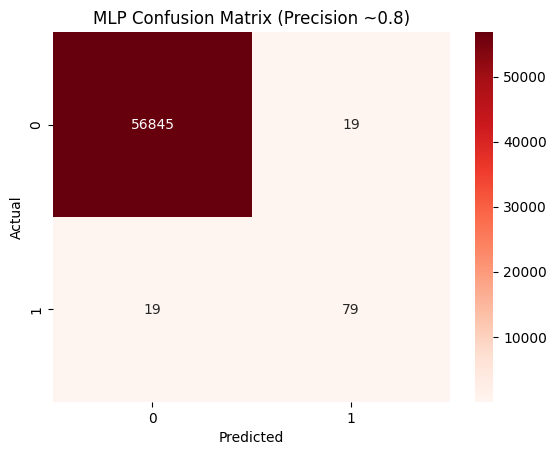

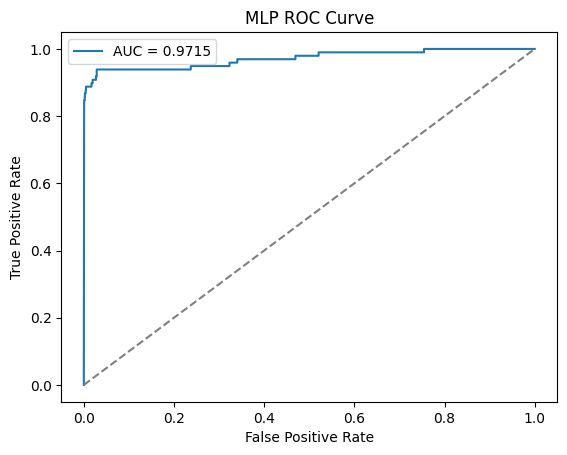

Saved model, scaler, and optimal threshold for deployment.


In [16]:
# ============================================
# Cell 7: Evaluation and saving threshold
# ============================================
classifier.eval()
with torch.no_grad():
    y_probs = classifier(X_test_tensor.to(device)).squeeze().cpu().numpy()

desired_precision = 0.80
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_probs)

mask = precision_vals[:-1] >= desired_precision
idx = np.argmax(mask) if mask.any() else np.argmax(precision_vals[:-1])
optimal_threshold = thresholds[idx]

print("Optimal threshold:", optimal_threshold)
print("Precision at threshold:", precision_vals[idx])
print("Recall at threshold:", recall_vals[idx])

y_pred = (y_probs >= optimal_threshold).astype(int)

classification_metrics(y_test, y_pred, y_probs)
plot_confusion_matrix(y_test, y_pred, f"MLP Confusion Matrix (Precision ~{desired_precision})")
plot_roc(y_test, y_probs, "MLP ROC Curve")

# Save model, scaler, and threshold
torch.save(classifier.state_dict(), "mlp_fraud_model.pth")
joblib.dump(scaler, "mlp_scaler_creditcard.joblib")
joblib.dump(optimal_threshold, "mlp_threshold.pkl")
print("Saved model, scaler, and optimal threshold for deployment.")

### Generalizability Testing on 2nd Dataset

Evaluates the trained **MLP model** on a **new, unseen dataset** to test how well the model generalizes beyond the original training data.

### [Dataset Link](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/data)

**Purpose**
- Ensure that the model is not overfitted to the original dataset.
- Assess performance on a more recent or different dataset for **generalizability**.
- Validate that preprocessing, scaling, and thresholding are consistent.

**Steps**

1. **Download & Load Dataset**
   - Fetches the 2023 credit card fraud dataset via Kagglehub.
   - Loads the CSV into a DataFrame.

2. **Feature Engineering**
   - Log-transform `Amount` → `Amount_log`.
   - Drop unnecessary columns: id, original Amount, and Class.
   - Extract target labels `y_2023`.

3. **Preprocessing & Scaling**
   - Load the previously fitted StandardScaler (`mlp_scaler_creditcard.joblib`) to maintain consistent preprocessing.
   - Scale `X_2023` for model input.
   - Ensure MLP classifier exists and is moved to the correct device (`cuda` or `cpu`).
   - Convert scaled features to PyTorch tensors.

4. **Prediction and Threshold Selection**
   - Predict probabilities with the MLP.
   - Use the **Precision-Recall curve** to determine the threshold achieving ≥0.80 precision.
   - Convert probabilities to binary predictions using the selected threshold.

5. **Evaluation**
   - Compute classification metrics: precision, recall, F1-score.
   - Visualize results through confusion matrix and ROC curve.
   - Confirms how the model generalizes to unseen data.

The intended desire for using scaled predictions and evaluation metrics on a secondary dataset to assess model's usuage on potential other real world examples.
- Provides quantitative analysis on how well the model performs on new, unseen data, unrelated to what was provided in training.



Using Colab cache for faster access to the 'credit-card-fraud-detection-dataset-2023' dataset.
Path to dataset files: /kaggle/input/credit-card-fraud-detection-dataset-2023
   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.14

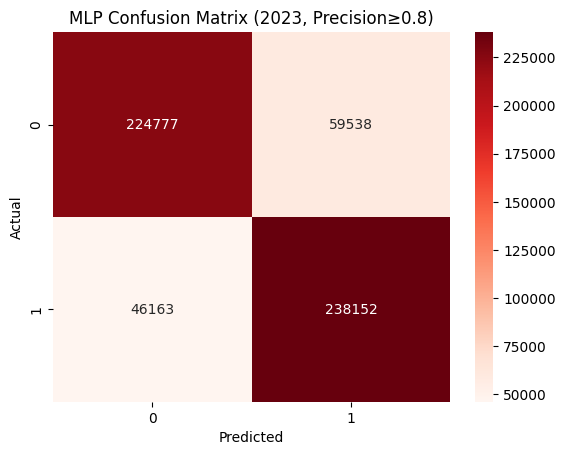

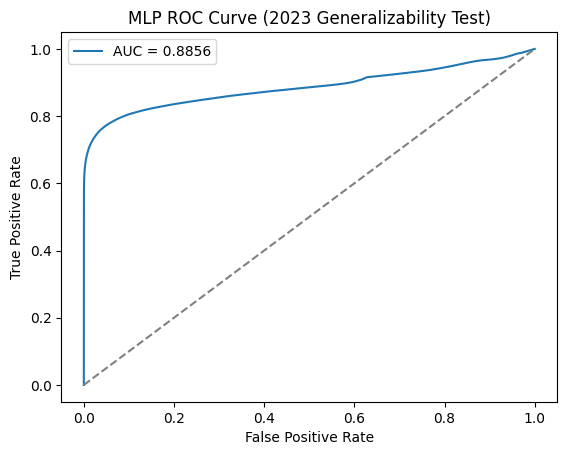

In [17]:
# ============================================
# Cell 8: Generalizability Testing through 2nd Dataset
# ============================================
# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load 2nd dataset dataset
path_2023 = kagglehub.dataset_download(
    "nelgiriyewithana/credit-card-fraud-detection-dataset-2023"
)
print("Path to dataset files:", path_2023)

# KaggleHub sometimes places files inside folder structure
csv_files = []
for root, dirs, files in os.walk(path_2023):
    for f in files:
        if f.endswith(".csv"):
            csv_files.append(os.path.join(root, f))

if len(csv_files) == 0:
    raise FileNotFoundError("No CSV file found in 2023 dataset!")

csv_2023_path = csv_files[0]
df_2023 = pd.read_csv(csv_2023_path)
print(df_2023.head())

# Feature Engineering
df_2023["Amount_log"] = np.log1p(df_2023["Amount"])

X_2023 = df_2023.drop(["id", "Amount", "Class"], axis=1)
y_2023 = df_2023["Class"].values

# Load original scaler
if not os.path.exists("mlp_scaler_creditcard.joblib"):
    print("mlp_scaler_creditcard.joblib NOT FOUND! Using fresh StandardScaler() instead.")
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_2023)     # Not ideal—should use original scaler.
else:
    scaler = joblib.load("mlp_scaler_creditcard.joblib")

X_2023_scaled = scaler.transform(X_2023)
print("2023 dataset shape:", X_2023_scaled.shape)

# Check that classifier exists
try:
    classifier
except NameError:
    raise NameError("MLP classifier is not defined. Train the MLP before running this cell.")

classifier.to(device)
classifier.eval()

# Convert to tensor
X_2023_tensor = torch.tensor(X_2023_scaled, dtype=torch.float32).to(device)

# Predict with MLP
with torch.no_grad():
    probs_2023 = classifier(X_2023_tensor).squeeze().cpu().numpy()

# Find optimal threshold (≥0.80 precision)
precision_vals, recall_vals, thresholds = precision_recall_curve(y_2023, probs_2023)

desired_precision = 0.80
mask = precision_vals[:-1] >= desired_precision   # last element has no threshold

if mask.any():
    idx = np.argmax(mask)
else:
    print("⚠ No threshold reached precision >= 0.80. Using highest available precision.")
    idx = np.argmax(precision_vals[:-1])

optimal_threshold = thresholds[idx]

print("\n===== Optimal Threshold Results (MLP 2023) =====")
print("Optimal threshold:", optimal_threshold)
print("Precision:", precision_vals[idx])
print("Recall:", recall_vals[idx])

# Predictions
y_pred_2023 = (probs_2023 >= optimal_threshold).astype(int)

# Evaluation
try:
    classification_metrics(y_2023, y_pred_2023, probs_2023)
except NameError:
    print("classification_metrics() not defined in this notebook.")

try:
    plot_confusion_matrix(
        y_2023, y_pred_2023,
        f"MLP Confusion Matrix (2023, Precision≥{desired_precision})"
    )
except NameError:
    print("plot_confusion_matrix() not defined in this notebook.")

try:
    plot_roc(y_2023, probs_2023, "MLP ROC Curve (2023 Generalizability Test)")
except NameError:
    print("plot_roc() not defined in this notebook.")
